# Functions in project 2

In [1]:
import keyboard
import time
import wave
import pyaudio
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

# Divide signal data into 20ms segements with 10ms interval for every two consecutive ones 
def create_segments(signal,sample_rate,width=10):
    num=int(width*sample_rate/1000)
    # first divide signal into 10ms segments
    ten_ms_segments = [signal[i:i+num] for i in range(0, len(signal), num)]
    twenty_ms_segments =[]
    for j in range(len(ten_ms_segments)):
        if j!=0:
            l1=ten_ms_segments[j-1]
            l2=ten_ms_segments[j]
            l=[0 for i in range(num*2)]
            for k in range(len(l1)):
                l[k]=l1[k]
                l[k+len(l1)]=l2[k]
            twenty_ms_segments.append(l)
    return twenty_ms_segments

# Preemphasize each segement
def Preemphasizing(segment):
    pre=np.zeros(len(segment))
    pre[0]=segment[0]
    for i in range(1,len(segment)):
        pre[i]=segment[i]-0.95*segment[i-1]
    return pre

# Window each preemphasized segement
def windowing(pre):
    pre=pre*np.hamming(len(pre))
    return pre

# Zero pad each windowed segement
def zero_padding(windowed):
    #zero padding for FFT
    length=512
    windowed_len=len(windowed)
    padding_len=length-windowed_len
    zeros=np.zeros((padding_len,))
    zero_padded=np.concatenate((windowed,zeros))
    return zero_padded

# Calculate the power spectrum of a segement
def FFT(frame):
    length=512
    fft=np.fft.rfft(frame, length)
    magnitude = np.abs(fft)
    power = ((1.0 / length) * ((magnitude) ** 2)) 

    return power

# Mel warping function
def warping_function(Hz):
    Mel = 2595 * np.log10(1+Hz/700)
    return Mel
# inverse function
def inverse_warping(Mel):
    Hz = 700*(np.power(10,Mel/2595)-1) 
    return Hz

# calculate mel spectra and log mel spectra
def filterbanks(power,filter_num,minHz=133.33,maxHz=6855.4976,length=512):
    maxMel=warping_function(maxHz)
    minMel=warping_function(minHz)
    #get start and end points of triangle filters in Mel
    pointsInMel=np.linspace(minMel,maxMel,filter_num+2)
    #get start and end points of triangle filters in Hz
    pointsInHz=inverse_warping(pointsInMel)
    #get start and end points of tiangle filters in total 257 points
    ranges=np.floor(length/2*pointsInHz/(maxHz-minHz))
    #normalize the triangle filters according to the lower bound
    ranges=ranges-ranges[0]
    #create filter banks with size(number of filters=40, points in power spectrum=257)
    filter_banks=np.zeros((filter_num,len(power)))
    for i in range(1,filter_num+1): 
        #get the left half of the traingle
        for j in range(int(ranges[i-1]),int(ranges[i])):
            filter_banks[i-1,j]=(j-ranges[i-1])/(ranges[i]-ranges[i-1])
        #get the right half of the traingle
        for j in range(int(ranges[i]),int(ranges[i+1])):
            filter_banks[i-1,j]=(ranges[i+1]-j)/(ranges[i+1]-ranges[i])
    #mel spectrum
    filter_banks=filter_banks.T
    Mel=np.dot(power,filter_banks)
    Mel=np.where(Mel==0,np.finfo(float).eps,Mel)
    #log mel spectrum
    Log_Mel=10*np.log(Mel) 
    return Mel,Log_Mel

from scipy.fftpack import dct,idct
# use dct to get the cepstral_coefficients
def mel_cepstrum(log_mel):
    cepstral_coefficients=dct(log_mel,axis=-1, type=2, norm='ortho')
    return cepstral_coefficients[:13]

# get idct
def IDCT(log_mel,num):
    IDCT_coefficients=idct(log_mel,type=2, n=num, norm='ortho')
    return IDCT_coefficients

# get log mel spectrum matrix, mel cpestrum matrix and idct matrix, given segments
def get_matrix(segments,num):
    Mel_cepstrum_matrix=[]
    log_Mel_spectrum_matrix=[]
    IDCT_matrix=[]
    for i in range(len(segments)):
        preemphasized=Preemphasizing(segments[i])
        windowed=windowing(preemphasized)
        zero_padded=zero_padding(windowed)
        power_spectrum=FFT(zero_padded)
        Mel_spectrum, log_Mel_spectrum=filterbanks(power_spectrum,num)
        log_Mel_spectrum_matrix.append(log_Mel_spectrum)
        Mel_cepstrum=mel_cepstrum(log_Mel_spectrum)
        Mel_cepstrum_matrix.append(Mel_cepstrum)
        IDCT_spectrum=IDCT(Mel_cepstrum,num)
        IDCT_matrix.append(IDCT_spectrum)
    return log_Mel_spectrum_matrix,Mel_cepstrum_matrix,IDCT_matrix
#plot the spectrum and cepstrum
def plot_show(matrix, title):
    plt.figure(figsize=(15, 8))
    plt.subplot(311)
    plt.imshow(matrix.T, origin='lower')
    plt.title(title)

#load wav file
def load_wav(file_path):
    wav_file = wave.open(file_path, 'r')
    # Get the audio data
    frames = wav_file.readframes(-1)
    signal = np.frombuffer(frames, dtype=np.int16)

    # Get the sample rate and time axis
    sample_rate = wav_file.getframerate()
    duration = len(signal) / sample_rate
    time = np.linspace(0., duration, len(signal))
    
    # Close the WAV file
    wav_file.close()
    return signal, sample_rate

# Mean subtraction and variance normalization

In [2]:
def mean_subtraction(matrix):
    means = np.mean(matrix, axis=0)/(np.shape(matrix)[0])
    matrix=matrix-means
    return matrix

def var_normalization(matrix):
    sd=np.sqrt(np.sum(np.square(matrix),axis=0)/(np.shape(matrix)[0]))
    return matrix*(1/sd)

## Get cepstrum feature

In [3]:
def get_cepstrum_features(file):
    signal, sample_rate=load_wav(file)
    seg=create_segments(signal,sample_rate)
    log_mel_spectrum_matrix,mel_cepstrum_matrix,IDCT_matrix=get_matrix(seg,40)
    log_mel_spectrum_matrix,mel_cepstrum_matrix,IDCT_matrix=np.array(log_mel_spectrum_matrix),np.array(mel_cepstrum_matrix),np.array(IDCT_matrix)

    mean_subtracted=mean_subtraction(mel_cepstrum_matrix)
    var_normalized=var_normalization(mean_subtracted)
    return var_normalized

## DTW

In [76]:
# calculate the Euclidean distance between two feature vectors
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


def DTW(input, template):       
    new_array=np.full(len(template),np.inf)
    old_array=np.full(len(template),np.inf)
    for i in range(len(input)):
        if i==0:
            old_array[0]=euclidean_distance(input[i],template[0])
        else:
            for j in range(len(template)):
                if j==0:
                    new_array[0]=old_array[0]+euclidean_distance(input[i], template[j])
                elif j==1:
                    cost=min(old_array[j-1],old_array[j])
                    new_array[1]=euclidean_distance(input[i],template[j])+cost
                else:
                    cost=min(old_array[j-1],old_array[j-2],old_array[j])
                    new_array[j]=euclidean_distance(input[i],template[j])+cost
            old_array=new_array
            new_array=np.full(len(template),np.inf)
               
    # Return the DTW distance
    return old_array[len(template)-1]

In [5]:
template_feature_matrix=[]
for i in range(10):
    template_feature=get_cepstrum_features(str(i)+'_template.wav')
    template_feature_matrix.append(template_feature)
dtw_result=np.zeros((10,2))

def DTW_recognition(templates):
    result=np.zeros((len(templates),2))
    for i in range(len(templates)):
        for j in range(1,3):
            training_feature=get_cepstrum_features(str(i)+'_training_'+str(j)+'.wav')
            dtw=DTW(training_feature,templates[0])
            type=0
            for k in range(1,10):
                cur_dtw=DTW(training_feature,template_feature_matrix[k])
                if cur_dtw<dtw:
                    dtw=cur_dtw
                    type=k
            result[i][j-1]=type
    return result

## Simple DTW accuracy

In [77]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a))
dtw_result=DTW_recognition(template_feature_matrix)
print(dtw_result)
differing_positions = dtw_result != correct_classifications
print('DTW Accuracy:',1-np.sum(differing_positions)/20)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0.]
 [1. 1.]
 [2. 2.]
 [3. 3.]
 [1. 4.]
 [5. 5.]
 [6. 6.]
 [7. 7.]
 [8. 8.]
 [9. 9.]]
DTW Accuracy: 0.95
Runtime: 15.168954 seconds


## Time-synchronous DTW

In [27]:
def Time_synchronous_DTW(input,templates):     
    template_len=[0]
    for i in range(10):
        if i==0: template_len.append(np.shape(templates[i])[0])
        else: template_len.append(template_len[-1]+np.shape(templates[i])[0])
    # template_len = [0, 99, 168, 267, 366, 465, 564, 663, 762, 861, 960]
    new_array=np.full(template_len[-1],np.inf)
    old_array=np.full(template_len[-1],np.inf)
    # i represents the number of vectors in the input
    for i in range(len(input)):
        if i==0:
            for k in range(len(template_len)-1):
                old_array[template_len[k]]=euclidean_distance(templates[k][0],input[i])
        else:
            for k in range(len(template_len)-1):
                low=template_len[k]
                high=template_len[k+1]
                new_array[low]=old_array[low]+euclidean_distance(templates[k][0],input[i])
                new_array[low+1]=min(old_array[low+1],old_array[low])+euclidean_distance(templates[k][1],input[i])
                for j in range(low+2,high): 
                    cost=min(old_array[j-2],old_array[j-1],old_array[j])
                    new_array[j]=euclidean_distance(templates[k][j-low],input[i])+cost
            old_array=new_array
            new_array=np.full(template_len[-1],np.inf)
            
    type=0
    dtw=old_array[template_len[1]-1]
    for i in range(2,len(template_len)):
        dist=old_array[template_len[i]-1]
        if dist<dtw:
            dtw=dist
            type=i-1
    return type
        


In [25]:
def TS_DTW_recognition(templates):
    result=np.zeros((len(templates),2))
    for i in range(len(templates)):
        for j in range(1,3):
            training_feature=get_cepstrum_features(str(i)+'_training_'+str(j)+'.wav')
            type=Time_synchronous_DTW(training_feature,templates)
            result[i][j-1]=type
    return result

## Time-synchronous DTW Accuracy

In [28]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a))
ts_dtw_result=TS_DTW_recognition(template_feature_matrix)
print(ts_dtw_result)
differing_positions = ts_dtw_result != correct_classifications
print('TS_DTW Accuracy:',1-np.sum(differing_positions)/20)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0.]
 [1. 1.]
 [2. 2.]
 [3. 3.]
 [1. 4.]
 [5. 5.]
 [6. 6.]
 [7. 7.]
 [8. 8.]
 [9. 9.]]
TS_DTW Accuracy: 0.95
Runtime: 14.532893 seconds


## TS-DTW with pruning

In [121]:
def Pruning(input,templates,threshold):     
    template_len=[0]
    for i in range(10):
        if i==0: template_len.append(np.shape(templates[i])[0])
        else: template_len.append(template_len[-1]+np.shape(templates[i])[0])
    # template_len = [0, 99, 168, 267, 366, 465, 564, 663, 762, 861, 960]
    new_array=np.full(template_len[-1],np.inf)
    old_array=np.full(template_len[-1],np.inf)
    # i represents the number of vectors in the input
    ranges=[[] for x in range(10)]
    best=np.full(len(templates),np.inf)
    for i in range(len(input)):
        if i==0:
            for k in range(len(template_len)-1): 
                cost=euclidean_distance(templates[k][0],input[i])
                old_array[template_len[k]]=euclidean_distance(templates[k][0],input[i])
                best[k]=cost
                ranges[k].append(template_len[k]) 
            # print(ranges,best)
        else:
            for k in range(len(template_len)-1):
                for y in range(len(ranges[k])):
                    if old_array[ranges[k][y]]>best[k]*(1+threshold):
                        old_array[ranges[k][y]]=np.inf
                ranges[k]=[]
                best[k]=np.inf
                low=template_len[k]
                high=template_len[k+1]
                new_array[low]=old_array[low]+euclidean_distance(templates[k][0],input[i])
                new_array[low+1]=min(old_array[low+1],old_array[low])+euclidean_distance(templates[k][1],input[i])
                best[k]=min(new_array[low],new_array[low+1])
                for j in range(low+2,high): 
                    cost=min(old_array[j-2],old_array[j-1],old_array[j])
                    if cost==np.inf: 
                        new_array[j]=cost
                    else: 
                        dist=euclidean_distance(templates[k][j-low],input[i])+cost
                        new_array[j]=dist
                        if dist<best[k]:
                            best[k]=dist
                        ranges[k].append(j)
            old_array=new_array
            new_array=np.full(template_len[-1],np.inf)            
    type=0
    dtw=old_array[template_len[1]-1]
    for i in range(2,len(template_len)):
        dist=old_array[template_len[i]-1]
        if dist<dtw:
            dtw=dist
            type=i-1
    return type
        


In [98]:
def Pruning_recognition(templates,threshold):
    result=np.zeros((len(templates),2))
    for i in range(len(templates)):
        for j in range(1,3):
            training_feature=get_cepstrum_features(str(i)+'_training_'+str(j)+'.wav')
            type=Pruning(training_feature,templates,threshold)
            result[i][j-1]=type
    return result

## Accuracy of time synchronous DTW with pruning

In [126]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a))
pruning_result=Pruning_recognition(template_feature_matrix,0.05)
print(pruning_result)
differing_positions = pruning_result != correct_classifications
print('TS_DTW_with_Pruning Accuracy:',1-np.sum(differing_positions)/20)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[2. 0.]
 [1. 1.]
 [2. 0.]
 [3. 3.]
 [1. 4.]
 [3. 5.]
 [6. 6.]
 [2. 7.]
 [8. 8.]
 [9. 9.]]
TS_DTW_with_Pruning Accuracy: 0.75
Runtime: 6.603256 seconds


## plot of different threshold

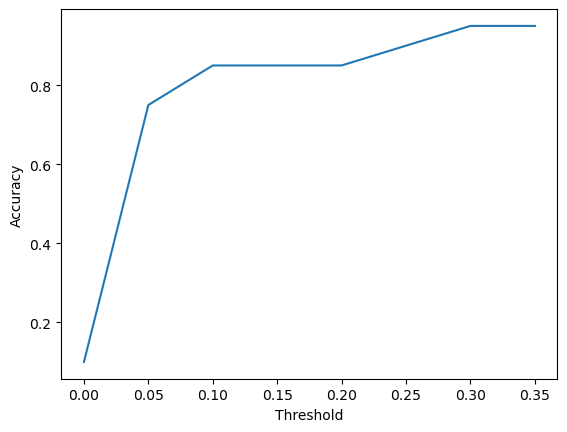

In [133]:
a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a))
accuracy=[]
for i in range(8):
    pruning_result=Pruning_recognition(template_feature_matrix,0.05*i)
    differing_positions = pruning_result != correct_classifications
    accuracy.append(1-np.sum(differing_positions)/20)
x = np.linspace(0.0,0.05*7,num=8)

plt.plot(x, accuracy)

plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.show()